We will begin to explore a real-world dataset and conduct important operations such as **preprocessing**, **numericalization**, **batching**, and **data loading**.


Can we use spaCy instead for NLP? We will avoid using these high level libraries so that the use can get a feel for the type of preprocessing steps that are necessary in NLP.

Demos a language classification problem to explain the concepts of NLP, other problems may advancer such as language generation.

In [0]:
import torch
import torch.nn as nn

In [3]:
# check if cuda is available in your computer
print("---------------------------------------------------")
print("Cuda status:", torch.cuda.is_available())

device_0 = torch.device("cuda")
device_1 = torch.device("cpu")

print("---------------------------------------------------")

---------------------------------------------------
Cuda status: True
---------------------------------------------------


In [4]:
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

mpl.style.use(['seaborn-whitegrid'])
print("Using style of 'seaborn-whitegrid' to plot")

Using style of 'seaborn-whitegrid' to plot


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# import other important libraries and functions

import numpy as np
import pandas as pd

import pickle

def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))

def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

In [6]:
# READ DATA FROM GOOGLE DRIVE
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# **Loading Data**

In [0]:
data = load_from_pickle(directory="/gdrive/My Drive/pycon2019/merged_training.pkl")

In [8]:
data                                                       # this is a preprocessed dataset, which is already cleansed and ready to analyze

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [9]:
data[:2]

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness


In [10]:
type(data)

pandas.core.frame.DataFrame

In [11]:
data.index

Int64Index([ 27383, 110083, 140764, 100071,   2837,  18231,  10714,  35177,
            122177,  26723,
            ...
              3416,  33952,  19091,   1580,   9372,    566,  36236,  76229,
            131640,  64703],
           dtype='int64', length=416809)

In [12]:
data.columns

Index(['text', 'emotions'], dtype='object')

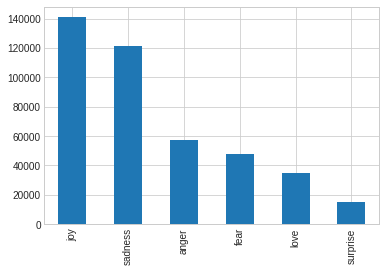

In [13]:
data.emotions.value_counts().plot.bar()
plt.show()

# **Preprocessing**
Our data is already clean in this notebook, but it is common to have to preprocess your data manually. For instance, let's assume we wanted to lowercase all text pieces.

# **Tokenizing and Sampling**
In the next steps we are going to tokenize the text, create index mapping for words, and also construct a vocabulary.italicized text

In [14]:
# retain only text that contain less that 70 tokens to avoid too much padding

data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 70].copy()

# sampling
data = data.sample(n=50000);

print(data.head(10))

                                                     text emotions  token_size
13462   i cant afford to let myself feel as low as i d...  sadness          30
60315        i feel safe in roller coasters and airplanes      joy           8
79597             i left so discouraged and feeling alone  sadness           7
68838   i have a feeling that this journal entry is do...  sadness          20
115490  i walk in and this girl is up there playing an...      joy          57
80429   i look at sweet mountain planet wisp and in so...  sadness          26
67596   i feel that if i havent convinced you that agg...      joy          23
2340    i am still feeling like she could be a little ...     love          13
79759   i let go then i see her steadily she looks ser...  sadness          47
1377    i almost never feel afraid is not because ther...     fear          13


In [15]:
data['text'][:2]

13462    i cant afford to let myself feel as low as i d...
60315         i feel safe in roller coasters and airplanes
Name: text, dtype: object

# **Building Vocabulary**
After tokenizing text, it's time to build the vocabulary, which is used to determine the features that we will be using to train the models.

In [0]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [17]:
# construct vocab and indexing
inputs = ConstructVocab(data["text"].values.tolist())

# examples of what is in the vocab
inputs.vocab[0:10]

['a',
 'aa',
 'aaa',
 'aaargh',
 'aabsolutely',
 'aac',
 'aad',
 'aainaa',
 'aaron',
 'aaryn']

# **Converting Data Into Tensors**

In [0]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [19]:
# examples of what is in the input tensors
input_tensor[0:2]

[[11588,
  3419,
  435,
  24475,
  13748,
  15759,
  8732,
  1305,
  14221,
  1305,
  11588,
  6448,
  24486,
  876,
  27121,
  12578,
  3383,
  25926,
  7369,
  25025,
  24475,
  2432,
  876,
  24135,
  11303,
  8742,
  11650,
  11704,
  16271,
  3494],
 [11588, 8732, 20650, 11856, 20396, 4383, 876, 580]]

#### **Obtaining Tensor Representation**
Convert the following sentences into their corresponding tensor representations.

In addition, try to combine/merge the representations into one tensor.

In [0]:
sent1 = 'Hello how is everthing doing?'
sent2 = 'I am doing okay!'

In [61]:
type(sent2)

str

In [62]:
# construct vocab and indexing
inputs_1 = ConstructVocab(sent1)

# examples of what is in the vocab
inputs_1.vocab

['', '?', 'H', 'd', 'e', 'g', 'h', 'i', 'l', 'n', 'o', 'r', 's', 't', 'v', 'w']

In [63]:
# construct vocab and indexing
inputs_2 = ConstructVocab(sent2)

# examples of what is in the vocab
inputs_2.vocab

['', '!', 'I', 'a', 'd', 'g', 'i', 'k', 'm', 'n', 'o', 'y']

# **Padding Data**
In order to train our recurrent neural network later on in the notebook, it is required padding to generate inputs of same length.

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [24]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

69


In [0]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [0]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [30]:
input_tensor[0:2]                                                        # all have the same size

[array([11588,  3419,   435, 24475, 13748, 15759,  8732,  1305, 14221,
         1305, 11588,  6448, 24486,   876, 27121, 12578,  3383, 25926,
         7369, 25025, 24475,  2432,   876, 24135, 11303,  8742, 11650,
        11704, 16271,  3494,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([11588,  8732, 20650, 11856, 20396,  4383,   876,   580,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

#### **Pad the tensor you created in the previous exercise**.

# **Binarization**
We would like to binarize our target so that we can obtain one-hot encodings as target values. These are easier and more efficient to work with and will be useful when training the models.

In [0]:
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)

# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [32]:
target_tensor[0:2] 

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0]])

In [33]:
data[0:2]

,text,emotions,token_size
13462,i cant afford to let myself feel as low as i d...,sadness,30
60315,i feel safe in roller coasters and airplanes,joy,8


In [0]:
get_emotion = lambda t: np.argmax(t)

In [35]:
get_emotion(target_tensor[0])

4

In [0]:
emotion_dict = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [37]:
emotion_dict[get_emotion(target_tensor[0])]

'sadness'

# **Split Data**
We would like to split our data into a train and validation set. In addition, we also want a holdout dataset (test set) for evaluating the models.

In [38]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

(40000, 40000, 5000, 5000, 5000, 5000)

# **Dataset and Data Loader**
We can also load the data into a data loader, which makes it easy to manipulate the data, create batches, and apply further transformations. In PyTorch we can use the DataLoader function.

In [0]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

We use the Dataset class to represent a dataset object. You override a few methods and you should be able to create the dataset object you need

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

Load the data and then and then pass it to an iterator called DataLoadder which helps to define how samples/batched should be prepared.

In [0]:
# Data instance
train_dataset = MyData(input_tensor_train, target_tensor_train)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)


# Data Loader instance
train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [43]:
val_dataset.batch_size

64

In [0]:
# val_dataset.dataset.data

In [45]:
num_emotions

6

# **Store the Data for Reuse**
Now we store the data to be reused in the next phase.

In [46]:
pwd

'/content'

In [47]:
ls

sample_data/


In [0]:
data_folder = "/gdrive/My Drive/NLP_PyTorch/"
convert_to_pickle(train_dataset, data_folder + "train_dataset")
convert_to_pickle(val_dataset, data_folder + "val_dataset")
convert_to_pickle(test_dataset, data_folder + "test_dataset")